## Facies classification using RandomForest algorithm

**Databases description**<br>

Training data:
- nine wells (4149 examples)
- seven predictor variables
- rock facies (class) for each example vector<br>

Test data: 
- 830 examples from two wells

**Features**<br>
Wire line log curves:
* GR - gamma ray,
* ILD_log10 - resistivity,
* PE - photoelectric effect,
* DeltaPHI - neutron-density porosity difference (DeltaPHI),
* PHIND - average neutron-density porosity

Geologic constraining variables:
* NM_M - marine indicator (1: Non-marine, 2: Marine),
* RELPOS - relative position

Target variable:
* Facies<br>
1: Nonmarine sandstone,<br>
2: Nonmarine coarse siltstone,<br>
3: Nonmarine fine siltstone,<br>
4: Marine siltstone and shale,<br>
5: Mudstone (limestone),<br>
6: Wackestone (limestone),<br>
7: Dolomite,<br>
8: Packstone-grainstone (limestone),<br>
9: Phylloid-algal bafflestone (limestone)<br>

Link: http://www.people.ku.edu/~gbohling/EECS833/

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [7]:
def print_full_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

In [8]:
class FeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_tr = X.copy()
        
        # one-hot-encoding of categorical features - Formation and Non-marine - Marine indicator
        X_tr = pd.get_dummies(X_tr, columns=['Formation', 'NM_M'], drop_first=True)
        X_tr.drop(['Well Name', 'RELPOS'], axis=1, inplace=True)
        return X_tr

In [9]:
def plot_curve(data, param, ax, color, 
               ylabels=True, title='$Well log curve$'):
    """
    Function for a plotting of well log curve
    
    Parameters
    ----------
    data: Pandas DataFrame
        DataFrame with well log data
        
    param: str
        Well log parameter to plot
        
    ax: Axes object
        Axes object for plotting of well log curve
        
    color: str or hexadecimal number
        Color of well log curve
        
    ylabels: bool, default=True
        Indicator of plotting or not labels of yaxis
        
    title: str, default='$Well log curve$'
        Title of the plot.
    """
    ax.plot(data[param], data['Depth'], color=color)
    ax.set_ylim(data['Depth'].min(), data['Depth'].max())
    
    delta = (data[param].max() - data[param].min()) * 0.1
    ax.set_xlim(data[param].min()-delta, data[param].max()+delta)
    ax.invert_yaxis()
    if not ylabels:
        ax.yaxis.set_ticklabels([])
    ax.set_title(title)
    ax.grid(linestyle='--')

In [10]:
def layer_plot_parameters(data, ax, title):
    """
    Funciton to define parameters of column plots (non-marine/marine indicator, facies)
    
    Parameters
    ----------
    data: Pandas DataFrame
        DataFrame with well log data
        
    ax: Axes object
        Axes object for plotting of well log curve
        
    title: str, default='$Well log curve$'
        Title of the plot
    """
    ax.set_ylim(data['Depth'].min(), data['Depth'].max())
    ax.set_xlim(-0.5, 0.5)
    ax.invert_yaxis()
    ax.grid(False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)  

In [11]:
def plot_facies(data, ax, col_name):
    """
    Function for plotting of facies
    
    Parameters
    ----------
    data: Pandas DataFrame
        DataFrame with well log data
        
    ax: Axes object
        Axes object for plotting of well log curve
        
    col_name: str
        Name of column to plot
    """
    for f in range(1, 10):  # iterate through all facies in column
        bottom = data[data[col_name]==f]['Depth'].values
        upper = data[data[col_name]==f]['Depth'].values - 0.5
        for i in range(len(bottom)):
            ax.fill_between([-1, 1], upper[i], bottom[i], color=facies_colors[f])
            
    layer_plot_parameters(data, ax=ax, title=col_name)

In [12]:
def plot_facies_legend(ax, facies_colors):
    for i in range(len(facies_colors)):
        ax.fill_between([-1, 1], y1=i, y2=i+1, 
                        color=facies_colors[i+1], edgecolor=facies_colors[i+1], alpha=0.6)
    ax.set_ylim(0, len(facies_colors))
    ax.set_xlim(-0.5, 0.5)
    ax.grid(False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticks_position('right')
    ax.set_xticks([])
    ax.yaxis.set(ticks=np.arange(0.5, len(facies_colors)), ticklabels=np.arange(1, len(facies_colors)+1))
    ax.tick_params(axis='y', color='white')

In [13]:
def plot_well_log_data(data, real_facies=True, pred_facies=False):
    """
    Function for plotting of well log data.
    
    Parameters
    ----------
    data: Pandas DataFrame
        DataFrame with well log data
        
    real_facies: bool, default=True
        Indicator of plotting or not real facies
        
    pred_facies: bool, default=False
        Indicator of plotting or not predicted facies
    """
    
    
    # define an amount of axes and plot parameters
    if real_facies and pred_facies:
        ncols=9
        gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 0.3, 0.7, 0.7, 0.1]}
    elif real_facies or pred_facies:
        ncols = 8
        gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 0.3, 0.7, 0.1]}
    elif (not real_facies) and (not pred_facies):
        ncols = 7
        gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 0.3, 0.1]}

       
    fig, axs = plt.subplots(nrows=1, ncols=ncols, 
                            figsize=(15, 10), gridspec_kw=gridspec_kw)
    
    
    # well log curves 
    for i, curve in enumerate(map(lambda x, y: (x, y), ['GR', 'ILD_log10', 'PE', 'DeltaPHI', 'PHIND'],
                                                       ['red', 'green', 'blue', 'black', 'grey'])):
        ylabels= True if i==0 else False   
        plot_curve(data, param=curve[0], ax=axs[i], ylabels=ylabels,
                   color=curve[1], title=curve[0])

    
    # nonmarine - marine indicator 
    # getting of bottom boundaries of non-marine and marine facies
    nm_bottom = data[np.gradient(data['NM_M']) > 0]['Depth'][::2].values
    m_bottom = data[np.gradient(data['NM_M']) < 0]['Depth'][::2].values
    
    m = []
    
    min_depth = np.concatenate([nm_bottom, m_bottom]).min()
    max_depth = np.concatenate([nm_bottom, m_bottom]).max()
    
    if (min_depth in nm_bottom) and (max_depth in nm_bottom):
        m = list(map(lambda x, y: (x, y), nm_bottom, np.append(m_bottom, data['Depth'].max())))
    elif (min_depth in nm_bottom) and (max_depth in m_bottom):
        m = list(map(lambda x, y: (x, y), nm_bottom, m_bottom))
    elif (max_depth in nm_bottom) and (min_depth in m_bottom):
        m = list(map(lambda x, y: (x, y), np.insert(nm_bottom, 0, data['Depth'].min()), np.append(m_bottom, data['Depth'].max())))
    elif (min_depth in m_bottom) and (max_depth in m_bottom):
        m = list(map(lambda x, y: (x, y), np.insert(nm_bottom, 0, data['Depth'].min()), m_bottom))

    # fill all column by the color of non marine facies
    axs[5].fill_between([-2, 2], 10000, 0, color='#957458', edgecolor='#957458', alpha=0.6) 
    
    # fill marine facies
    for i in range(len(m)):
        axs[5].fill_between([-1, 1], m[i][0], m[i][1], color='#6FBEEC', edgecolor='#6FBEEC', alpha=0.7)
    
    layer_plot_parameters(data, ax=axs[5], title='NM-M')
    
    
    # facies columns
    if real_facies and pred_facies:
        plot_facies(data, ax=axs[6], col_name='Facies')
        plot_facies(data, ax=axs[7], col_name='Pred Facies')
        plot_facies_legend(axs[8], facies_colors)
        
    elif real_facies or pred_facies:
        if real_facies:
            plot_facies(data, ax=axs[6], col_name='Facies')
        else:
            plot_facies(data, ax=axs[6], col_name='Pred Facies')
        plot_facies_legend(axs[7], facies_colors)

    plt.tight_layout();

In [14]:
facies_colors = {1: '#ffcb00', 2: '#d6fe9a', 3: '#adfd35',
                 4: '#ace4c8', 5: '#cfefdf', 6: '#bddbf1',
                 7: '#6bc3ff', 8: '#38b4b1', 9: '#60ccbf'}

In [15]:
train = pd.read_csv('./training_data.csv', sep=',')

In [16]:
test = pd.read_csv('./test_data.csv', sep=',', index_col=0)

In [17]:
train.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [18]:
test.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,3


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     3232 non-null   int64  
 1   Formation  3232 non-null   object 
 2   Well Name  3232 non-null   object 
 3   Depth      3232 non-null   float64
 4   GR         3232 non-null   float64
 5   ILD_log10  3232 non-null   float64
 6   DeltaPHI   3232 non-null   float64
 7   PHIND      3232 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       3232 non-null   int64  
 10  RELPOS     3232 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 277.9+ KB


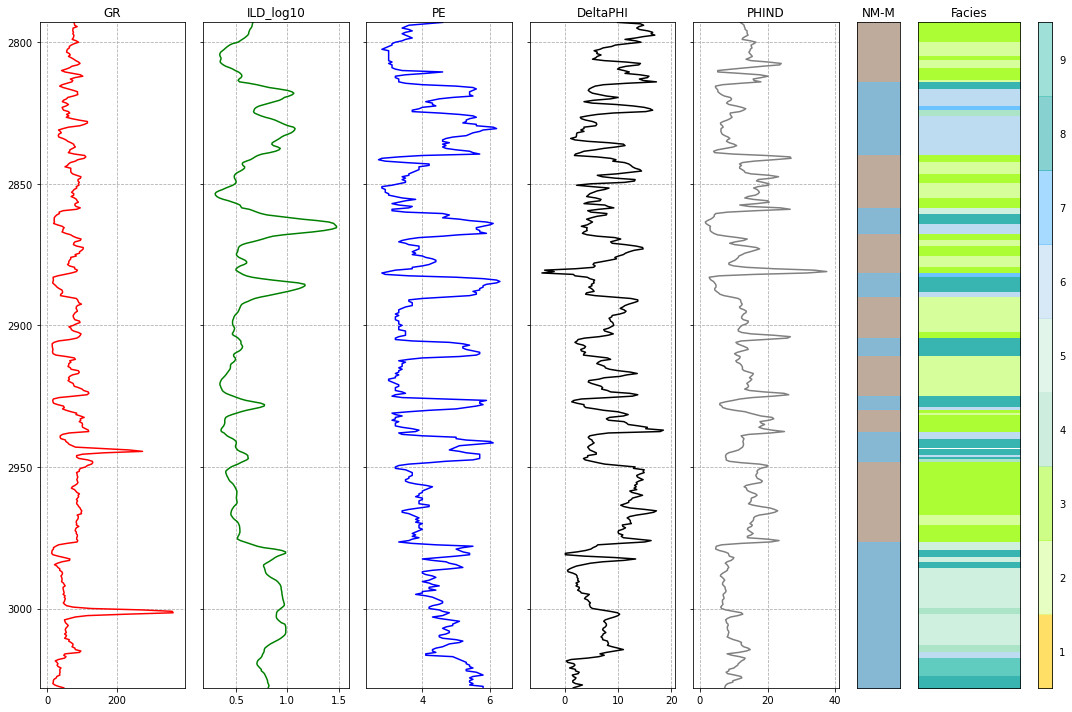

In [20]:
plot_well_log_data(data=train[train['Well Name']=='SHRIMPLIN'])

In [21]:
X = train.drop('Facies', axis=1).copy()
y = train['Facies'].copy()

In [22]:
X_test = test.drop('Facies', axis=1).copy()
y_test = test['Facies'].copy()

In [23]:
trans_feat = FeaturesTransformer()
trans_cols = ColumnTransformer(transformers=[('feat_trans', FeaturesTransformer(), []),
                                             ('scaler', StandardScaler(), np.arange(6).tolist())],
                                remainder='passthrough')

In [24]:
pipeline = Pipeline(steps=[('feat_tr', trans_feat),
                           ('cols_tr', trans_cols)])

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3,
                                                      stratify=y, random_state=1)

In [26]:
X_train_tr = pipeline.fit_transform(X_train)
X_valid_tr = pipeline.transform(X_valid)

In [27]:
X_test_tr = pipeline.transform(X_test)

In [28]:
forest = RandomForestClassifier()
cross_val_score(forest, X_train_tr, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()

0.7670280724374376

In [29]:
forest.fit(X_train_tr, y_train)
pred_forest = forest.predict(X_valid_tr)

In [30]:
print_full_report(y_valid, pred_forest)

              precision    recall  f1-score   support

           1       0.91      0.87      0.89        78
           2       0.81      0.83      0.82       222
           3       0.80      0.83      0.82       185
           4       0.75      0.73      0.74        55
           5       0.85      0.51      0.63        65
           6       0.71      0.78      0.74       139
           7       0.85      0.76      0.80        29
           8       0.73      0.79      0.76       149
           9       0.89      0.81      0.85        48

    accuracy                           0.79       970
   macro avg       0.81      0.77      0.78       970
weighted avg       0.79      0.79      0.79       970

[[ 68  10   0   0   0   0   0   0   0]
 [  6 185  31   0   0   0   0   0   0]
 [  1  29 154   0   0   1   0   0   0]
 [  0   0   0  40   3   7   0   5   0]
 [  0   1   1   5  33  12   0  13   0]
 [  0   0   1   6   2 109   2  19   0]
 [  0   0   1   1   0   2  22   2   1]
 [  0   2   4   1   1 

In [31]:
# param_grid = {
#     'n_estimators': [100, 150, 200],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 1, 5, 10],
#     'min_samples_split': [2, 4, 6],
#     'min_samples_leaf': [1, 3, 5]
# }

param_grid = {
    'n_estimators': np.arange(130, 144, 2),
    'criterion': ['entropy'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
grid_forest = GridSearchCV(forest, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_forest.fit(X_train_tr, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [None],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': array([130, 132, 134, 136, 138, 140, 142])},
             scoring='accuracy')

In [32]:
forest_best = grid_forest.best_estimator_

In [33]:
pred_forest = forest_best.predict(X_valid_tr)

In [34]:
print_full_report(y_valid, pred_forest)

              precision    recall  f1-score   support

           1       0.92      0.87      0.89        78
           2       0.82      0.85      0.83       222
           3       0.82      0.83      0.82       185
           4       0.74      0.67      0.70        55
           5       0.76      0.49      0.60        65
           6       0.69      0.78      0.73       139
           7       0.88      0.72      0.79        29
           8       0.73      0.79      0.76       149
           9       0.89      0.81      0.85        48

    accuracy                           0.79       970
   macro avg       0.80      0.76      0.78       970
weighted avg       0.79      0.79      0.79       970

[[ 68  10   0   0   0   0   0   0   0]
 [  5 189  28   0   0   0   0   0   0]
 [  1  29 153   0   1   1   0   0   0]
 [  0   0   0  37   4   8   0   6   0]
 [  0   1   1   5  32  15   0  11   0]
 [  0   0   1   6   4 108   2  18   0]
 [  0   0   1   0   0   2  21   4   1]
 [  0   2   3   1   1 

In [35]:
pred = forest_best.predict(X_test_tr)

In [36]:
print_full_report(y_test, pred)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        20
           2       0.68      0.75      0.71       159
           3       0.58      0.34      0.43       154
           4       0.75      0.58      0.66        65
           5       0.24      0.08      0.12        49
           6       0.44      0.64      0.52       127
           7       0.23      0.81      0.36        26
           8       0.71      0.68      0.70       212
           9       0.13      0.11      0.12        18

    accuracy                           0.56       830
   macro avg       0.42      0.44      0.40       830
weighted avg       0.57      0.56      0.55       830

[[  0  20   0   0   0   0   0   0   0]
 [  0 119  36   0   0   2   0   2   0]
 [  0  34  53   6   1   5  50   4   1]
 [  0   0   0  38  10  16   1   0   0]
 [  0   1   1   1   4  35   0   6   1]
 [  0   0   0   2   0  81  11  30   3]
 [  0   0   0   0   0   4  21   1   0]
 [  0   2   2   4   2 

In [37]:
print_full_report(y_test[X_test['Well Name']=='STUART'],
                  forest_best.predict(X_test_tr[X_test['Well Name']=='STUART']))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.76      0.65      0.70       110
           3       0.54      0.69      0.60        64
           4       0.74      0.57      0.64        49
           5       0.21      0.07      0.11        40
           6       0.37      0.64      0.47        61
           7       0.70      0.78      0.74         9
           8       0.68      0.75      0.72       117
           9       0.67      0.12      0.20        17

    accuracy                           0.59       474
   macro avg       0.52      0.47      0.46       474
weighted avg       0.60      0.59      0.58       474

[[ 0  7  0  0  0  0  0  0  0]
 [ 0 71 36  0  0  1  0  2  0]
 [ 0 13 44  4  0  2  0  1  0]
 [ 0  0  0 28 10 11  0  0  0]
 [ 0  1  1  1  3 30  0  4  0]
 [ 0  0  0  1  0 39  2 19  0]
 [ 0  0  0  0  0  2  7  0  0]
 [ 0  1  1  4  1 20  1 88  1]
 [ 0  0  0  0  0  0  0 15  2]]


In [38]:
print_full_report(y_test[X_test['Well Name']=='CRAWFORD'],
                  forest_best.predict(X_test_tr[X_test['Well Name']=='CRAWFORD']))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        13
           2       0.58      0.98      0.73        49
           3       0.90      0.10      0.18        90
           4       0.77      0.62      0.69        16
           5       0.33      0.11      0.17         9
           6       0.53      0.64      0.58        66
           7       0.17      0.82      0.29        17
           8       0.76      0.60      0.67        95
           9       0.00      0.00      0.00         1

    accuracy                           0.51       356
   macro avg       0.45      0.43      0.37       356
weighted avg       0.66      0.51      0.48       356

[[ 0 13  0  0  0  0  0  0  0]
 [ 0 48  0  0  0  1  0  0  0]
 [ 0 21  9  2  1  3 50  3  1]
 [ 0  0  0 10  0  5  1  0  0]
 [ 0  0  0  0  1  5  0  2  1]
 [ 0  0  0  1  0 42  9 11  3]
 [ 0  0  0  0  0  2 14  1  0]
 [ 0  1  1  0  1 21  7 57  7]
 [ 0  0  0  0  0  0  0  1  0]]


In [39]:
test['Pred Facies'] = pred

In [40]:
test['Well Name'].unique()

array(['STUART', 'CRAWFORD'], dtype=object)

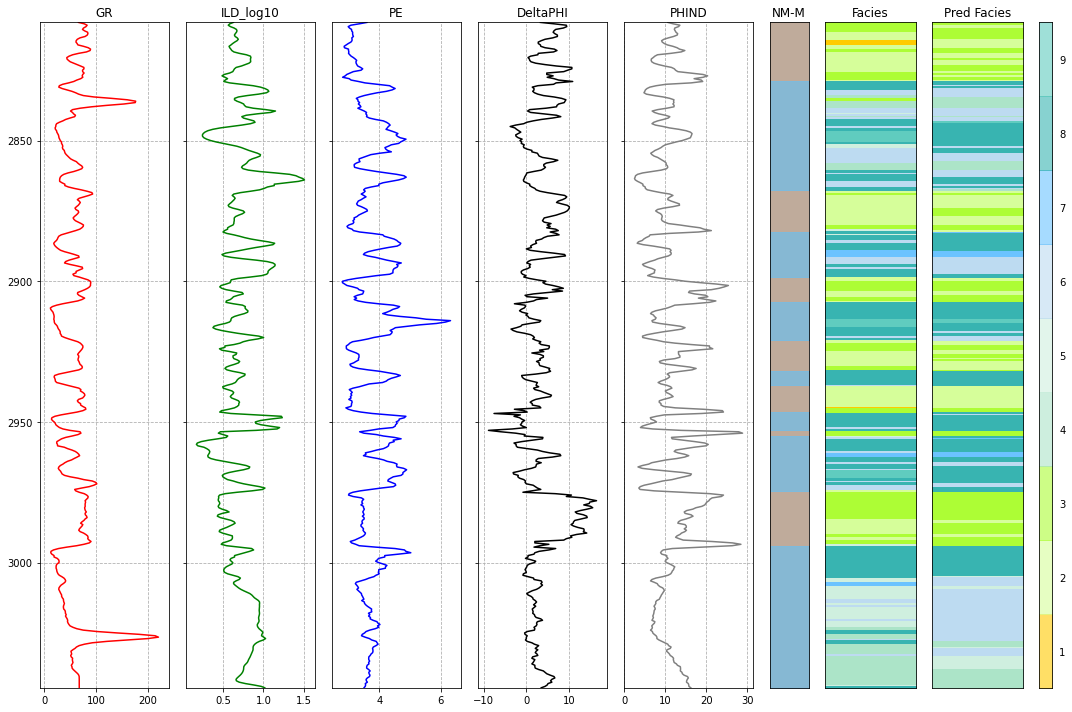

In [41]:
plot_well_log_data(test[test['Well Name']=='STUART'], pred_facies=True)

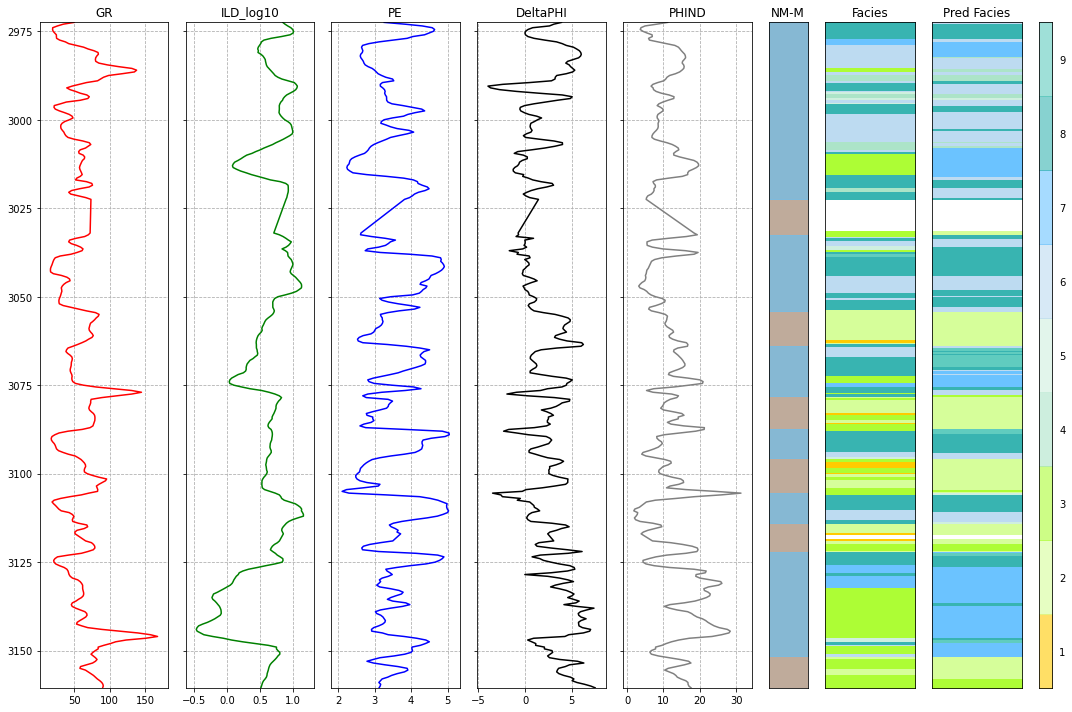

In [42]:
plot_well_log_data(test[test['Well Name']=='CRAWFORD'], pred_facies=True)

From the classification above one can see that Random Forest Classifier deals quite well with determination of facies. Even despite the fact that accuracy on the test dataset has reduced significantly (from 0.8 to 0.5) we are still able to differentiate non-marine and marine facies.<br>
It should be noticed that prediction on CRAWFORD drill hole is worse than prediction on STUART well (accuracies 0.6 vs 0.48).<br>

In [44]:
train = train.sample(frac=1)

In [46]:
train_X = train.drop('Facies', axis=1)
train_y = train['Facies']

In [48]:
train_X_tr = pipeline.fit_transform(train_X)

In [51]:
forest_best.fit(train_X_tr, train_y)

RandomForestClassifier(criterion='entropy', n_estimators=142)

In [53]:
print_full_report(y_test, forest_best.predict(X_test_tr))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        20
           2       0.70      0.78      0.74       159
           3       0.62      0.36      0.46       154
           4       0.72      0.55      0.63        65
           5       0.33      0.06      0.10        49
           6       0.43      0.62      0.51       127
           7       0.22      0.73      0.34        26
           8       0.68      0.68      0.68       212
           9       0.20      0.22      0.21        18

    accuracy                           0.56       830
   macro avg       0.43      0.45      0.41       830
weighted avg       0.58      0.56      0.55       830

[[  0  20   0   0   0   0   0   0   0]
 [  0 124  31   0   0   2   0   2   0]
 [  0  31  56   7   1   3  48   6   2]
 [  0   0   0  36   4  19   2   4   0]
 [  0   2   1   1   3  32   1   8   1]
 [  0   0   0   3   0  79  10  32   3]
 [  0   0   0   0   0   6  19   1   0]
 [  0   1   3   3   1 

In [58]:
test['Pred Facies'] = forest_best.predict(X_test_tr)

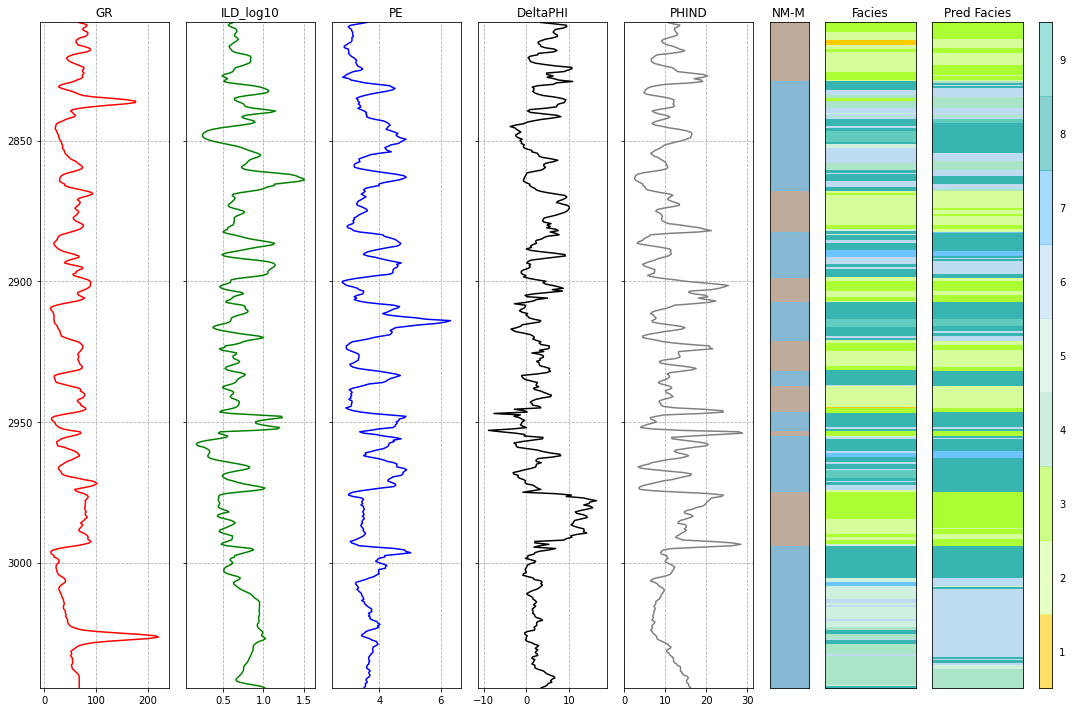

In [59]:
plot_well_log_data(test[test['Well Name']=='STUART'], pred_facies=True)

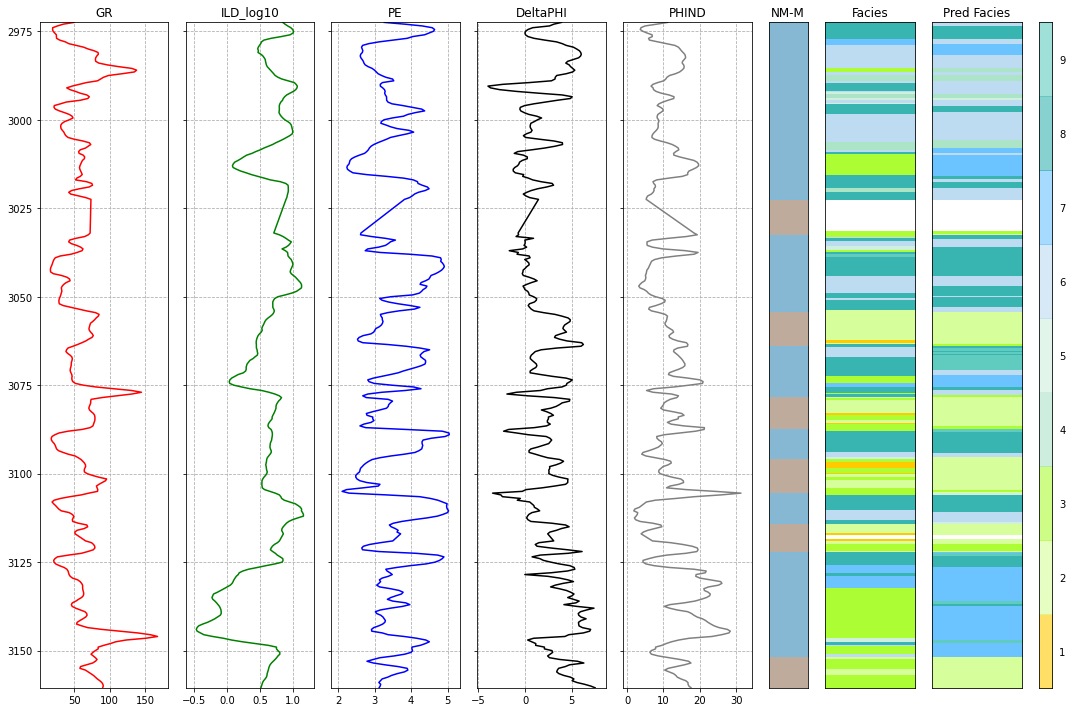

In [60]:
plot_well_log_data(test[test['Well Name']=='CRAWFORD'], pred_facies=True)